In [1]:
import gc
import sys
import os
import warnings

sys.path.append(os.path.abspath("modules/"))
sys.path.append(os.path.abspath("fe_modules/"))
sys.path.append(os.path.abspath("seq2seq_modules/"))

os.environ['OPENBLAS_NUM_THREADS'] = '1'
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import time
import polars as pl
import scipy
import implicit
import bisect
import sklearn.metrics as m
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve, CalibratedClassifierCV

In [3]:
import importlib

import modules
import fe_modules

importlib.reload(modules)
importlib.reload(fe_modules)

from modules.memory_utils import pandas_reduce_mem_usage, pandas_string_to_cat, my_reset
from fe_modules.text_manipulation import get_domain
from fe_modules.datetime_features import get_timestamp, get_relative_time, part_of_day_to_hour, add_hour_to_date
from fe_modules.preprocessing import clean_os_type

# Load data

In [4]:
LOCAL_DATA_PATH = './data/'
SPLIT_SEED = 42

In [5]:
df = pandas_reduce_mem_usage( 
        pd.read_parquet(
            f'{LOCAL_DATA_PATH}competition_data_final_pqt/'
    ))
df

Memory usage of dataframe is 29562.33 MB


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:03<00:00,  3.46it/s]

Memory usage after optimization is: 24943.21 MB
Decreased by 15.6%


,region_name,city_name,cpe_manufacturer_name,cpe_model_name,url_host,cpe_type_cd,cpe_model_os_type,price,date,part_of_day,request_cnt,user_id
0,Краснодарский край,Краснодар,Apple,iPhone 7,ad.adriver.ru,smartphone,iOS,20368.0,2022-06-15,morning,1,45098
1,Краснодарский край,Краснодар,Apple,iPhone 7,apple.com,smartphone,iOS,20368.0,2022-06-19,morning,1,45098
2,Краснодарский край,Краснодар,Apple,iPhone 7,avatars.mds.yandex.net,smartphone,iOS,20368.0,2022-06-12,day,1,45098
3,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-16,day,1,45098
4,Краснодарский край,Краснодар,Apple,iPhone 7,googleads.g.doubleclick.net,smartphone,iOS,20368.0,2022-05-30,day,1,45098
...,...,...,...,...,...,...,...,...,...,...,...,...
322899430,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,avatars.mds.yandex.net,smartphone,Android,16376.0,2021-07-12,morning,1,300964
322899431,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,googleads.g.doubleclick.net,smartphone,Android,16376.0,2021-06-20,evening,1,300964
322899432,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,online.sberbank.ru,smartphone,Android,16376.0,2021-08-05,day,1,300964
322899433,Калужская область,Обнинск,Samsung,Galaxy A30s Dual,s0.2mdn.net,smartphone,Android,16376.0,2021-07-19,evening,1,300964


In [29]:
copy_df = pd.DataFrame({'site_name': df['url_host'].unique()})

In [30]:
copy_df

,site_name
0,ad.adriver.ru
1,apple.com
2,avatars.mds.yandex.net
3,googleads.g.doubleclick.net
4,i.ytimg.com
...,...
199678,poliglot1.com
199679,reservemaster.ru
199680,uploadhive.com
199681,kuzma2012.livejournal.com


In [31]:
df["url_host"].value_counts().info()

<class 'pandas.core.series.Series'>
Index: 199683 entries, googleads.g.doubleclick.net to stroitelnye-materialy-v-kurske.ru
Series name: url_host
Non-Null Count   Dtype
--------------   -----
199683 non-null  int64
dtypes: int64(1)
memory usage: 3.0+ MB


In [18]:
copy_df['counts'] = df["url_host"].value_counts()

In [52]:
copy_df = pd.DataFrame(df["url_host"].value_counts()).rename(columns={'url_host':'counts'})
copy_df["url_host"] = copy_df.index
copy_df = copy_df.sort_values(by='counts', ascending=False)

In [53]:
from tqdm import tqdm

In [54]:
x = list(range(len(copy_df.counts)))
y = list(copy_df.counts.apply(lambda y: y / copy_df.counts.sum()))
summ = 0
for i in  tqdm(range(len(y))):
    summ += y[i]
    y[i] = summ

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 199683/199683 [00:00<00:00, 4166220.82it/s]


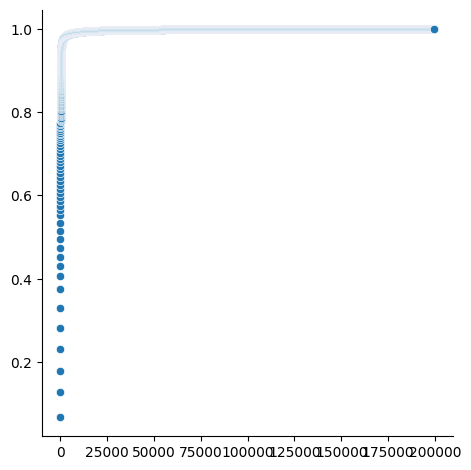

In [57]:
import seaborn as sns    

sns.relplot(x=x, y=y)

In [62]:
y[10000]

0.9926991479560867

In [65]:
copy_df[:10_000]["url_host"].to_csv("top_10k_urls.csv", index=False)